In [45]:
import os
import pretty_midi
import numpy as np
import os
import pretty_midi
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:

# Path to the directory containing MIDI files
base_dir = './Composer_Dataset/NN_midi_files_extended/train'


# List of folders (composers) within the base directory
composer_folders = os.listdir(base_dir)

# Initialize a list to store all loaded MIDI data
all_midi_data = []

# Function to load MIDI files from the specified directory
def load_midi_files(base_dir):
    # Loop through each composer folder
    for composer_folder in composer_folders:
        composer_path = os.path.join(base_dir, composer_folder)
        
        # Check if the item in the base directory is a folder
        if os.path.isdir(composer_path):
            print(f"Loading MIDI files from {composer_folder}...")
            
            # Loop through each MIDI file in the composer folder
            for file_name in os.listdir(composer_path):
                file_path = os.path.join(composer_path, file_name)
                
                # Check if the item in the composer folder is a file and has a .mid or .midi extension
                if os.path.isfile(file_path) and (file_name.endswith('.mid')):
                    midi_data = pretty_midi.PrettyMIDI(file_path)
                    all_midi_data.append({
                        'composer': composer_folder,
                        'file_name': file_name,
                        'midi_data': midi_data
                    })
                    print(f"  Loaded: {file_name}")

    print("All MIDI files loaded successfully!")
    return all_midi_data

# Load all MIDI files from the specified directory
all_midi_data = load_midi_files(base_dir)


Loading MIDI files from bach...
  Loaded: bach342.mid
  Loaded: bach343.mid
  Loaded: bach345.mid
  Loaded: bach346.mid
  Loaded: bach347.mid
  Loaded: bach350.mid
  Loaded: bach351.mid
  Loaded: bach352.mid
  Loaded: bach353.mid
  Loaded: bach355.mid
  Loaded: bach357.mid
  Loaded: bach358.mid
  Loaded: bach360.mid
  Loaded: bach361.mid
  Loaded: bach362.mid
  Loaded: bach363.mid
  Loaded: bach364.mid
  Loaded: bach365.mid
  Loaded: bach366.mid
  Loaded: bach367.mid
  Loaded: bach368.mid
  Loaded: bach369.mid
  Loaded: bach370.mid
  Loaded: bach371.mid
  Loaded: bach372.mid
  Loaded: bach373.mid
  Loaded: bach374.mid
  Loaded: bach375.mid
  Loaded: bach377.mid
  Loaded: bach378.mid
  Loaded: bach379.mid
  Loaded: bach380.mid
  Loaded: bach381.mid
  Loaded: bach382.mid
  Loaded: bach383.mid
  Loaded: bach385.mid
  Loaded: bach386.mid
  Loaded: bach387.mid
  Loaded: bach388.mid
  Loaded: bach389.mid
  Loaded: bach390.mid
  Loaded: bach391.mid
Loading MIDI files from bartok...
  Loaded: 

C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


  Loaded: chopin054.mid
  Loaded: chopin055.mid
  Loaded: chopin056.mid
  Loaded: chopin057.mid
  Loaded: chopin058.mid
  Loaded: chopin059.mid
  Loaded: chopin060.mid
  Loaded: chopin063.mid
  Loaded: chopin064.mid
  Loaded: chopin065.mid
  Loaded: chopin067.mid
  Loaded: chopin068.mid
  Loaded: chopin071.mid
  Loaded: chopin072.mid
  Loaded: chopin073.mid
  Loaded: chopin074.mid
  Loaded: chopin075.mid
  Loaded: chopin076.mid
  Loaded: chopin077.mid
  Loaded: chopin079.mid
  Loaded: chopin080.mid
  Loaded: chopin081.mid
  Loaded: chopin082.mid
  Loaded: chopin083.mid
  Loaded: chopin084.mid
  Loaded: chopin085.mid
  Loaded: chopin088.mid
  Loaded: chopin089.mid
  Loaded: chopin090.mid
  Loaded: chopin091.mid
  Loaded: chopin092.mid
  Loaded: chopin093.mid
  Loaded: chopin094.mid
  Loaded: chopin095.mid
  Loaded: chopin096.mid
  Loaded: chopin097.mid
  Loaded: chopin098.mid
Loading MIDI files from handel...
  Loaded: handel099.mid
  Loaded: handel100.mid
  Loaded: handel101.mid
  Load

# Feature Engineering

In [47]:

# Initialize lists to store extracted features
num_instruments_list = []
instruments_list_list = []
num_programs_list = []
tempo_list = []
composer_list = []
resolution_list = []
time_signature_ratio_list = []
duration_list = []
average_pitch_list = []

# Function to extract features from MIDI data
def feature_extraction(midi_data):
    # Loop through all loaded MIDI data
    for data in all_midi_data:
        midi_data = data['midi_data']
        
        # Extract the number of instruments
        num_instruments = len(midi_data.instruments)
        num_instruments_list.append(num_instruments)
        
        # Extract the list of instruments
        instruments_list = [instrument.program for instrument in midi_data.instruments]
        # flatten the list
        instruments_list_list.append(instruments_list)
        
        # Extract the number of programs
        num_programs = len(set(instruments_list))
        num_programs_list.append(num_programs)
        
        # Extract the tempo
        tempo = midi_data.estimate_tempo()
        tempo_list.append(tempo)
        
        # Extract the composer name
        composer = data['composer']
        composer_list.append(composer)

        # resolution
        resolution = midi_data.resolution
        resolution_list.append(resolution)

        #time_signature_ratio- Take numerator and denominator of time signature and divide them
        if len(midi_data.time_signature_changes) <=0:
            time_signature_ratio = 0
            time_signature_ratio_list.append(time_signature_ratio)
        else:
            time_sig_numerator =  midi_data.time_signature_changes[0].numerator
            time_sig_denominator = midi_data.time_signature_changes[0].denominator
            time_signature_ratio = time_sig_numerator/time_sig_denominator
            time_signature_ratio_list.append(time_signature_ratio)

        # duration
        duration = midi_data.get_end_time()
        duration_list.append(duration)

        # average_pitch
        pitch_list = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                pitch_list.append(note.pitch)
        average_pitch = np.mean(pitch_list)
        average_pitch_list.append(average_pitch)


    # # Create a DataFrame to store the extracted features
    import pandas as pd
    df = pd.DataFrame({
        'composer': composer_list,
        'num_instruments': num_instruments_list,
        'instruments_list': instruments_list_list,
        'num_programs': num_programs_list,
        'tempo': tempo_list,
        'resolution': resolution_list,
        'time_signature_ratio': time_signature_ratio_list,
        'duration': duration_list,
        'average_pitch': average_pitch_list
    })

    return df

# Extract features from the loaded MIDI data
df = feature_extraction(all_midi_data)
print('Feature extraction complete!')
df.head()

Feature extraction complete!


,composer,num_instruments,instruments_list,num_programs,tempo,resolution,time_signature_ratio,duration,average_pitch
0,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,248.235754,384,1.0,914.875000,63.972681
1,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,233.938023,384,0.0,445.690104,67.986739
2,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,266.035285,384,1.0,89.213542,64.177885
3,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,230.553293,384,1.0,103.048177,64.491651
4,bach,12,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]",1,175.318569,384,1.0,91.907552,62.205387


# Data Exploration

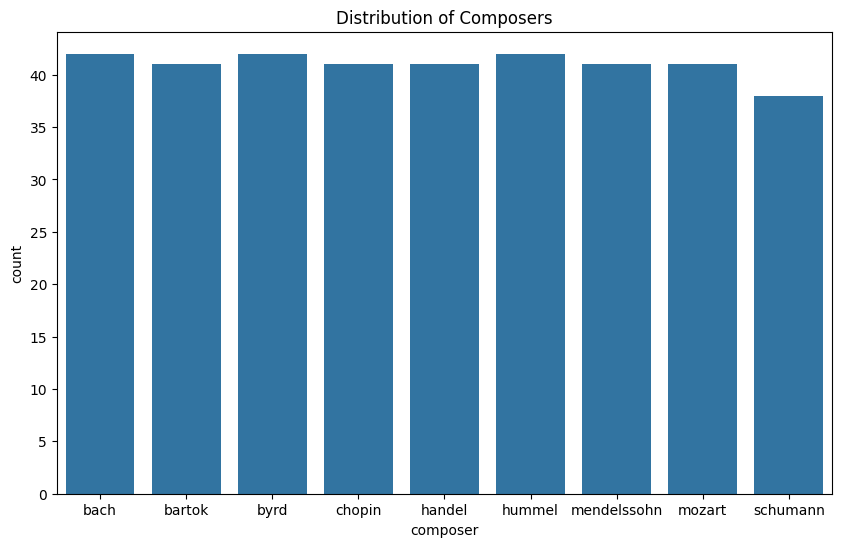

In [48]:
# Display the number of unique composers
df['composer'].value_counts()

# Display the distribution of composers
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer')
plt.title('Distribution of Composers')
plt.show()


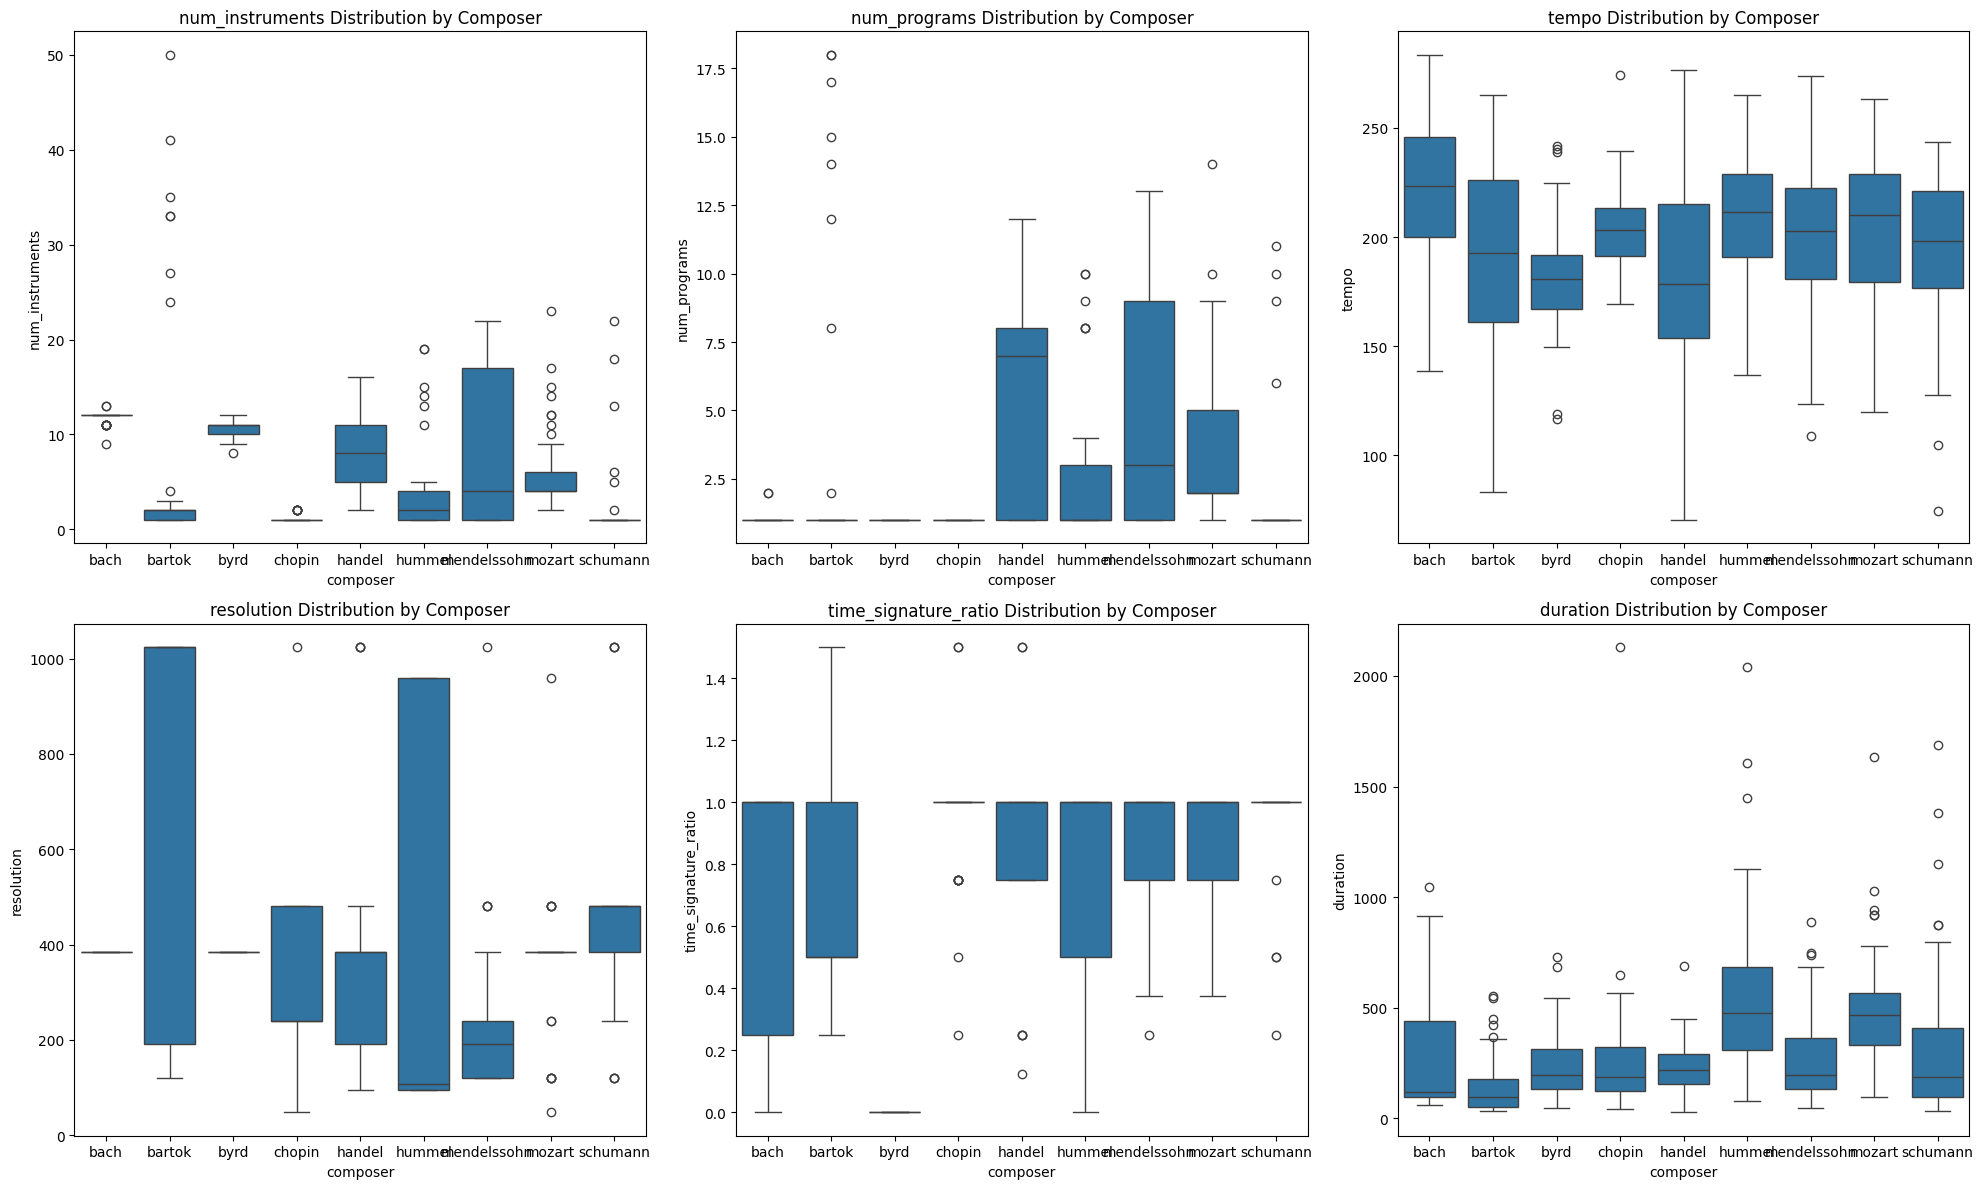

In [52]:
# Create a list of features to plot
features = ['num_instruments', 'num_programs', 'tempo', 'resolution', 'time_signature_ratio', 'duration', 'average_pitch']

# Plot the feature distributions side by side 
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for i, feature in enumerate(features):
    if feature == 'average_pitch':
        continue
    sns.boxplot(data=df, x='composer', y=feature, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'{feature} Distribution by Composer')
plt.tight_layout()
plt.show()




# Preprocessing

In [50]:
# Outlier Removal
from scipy.stats import zscore

# Calculate the z-scores of each feature in the DataFrame
z_scores = df[features].apply(zscore)

# Find the indices of rows with outliers
outlier_indices = z_scores[(z_scores > 3).any(axis=1)].index

# Remove rows with outliers
df_clean = df.drop(outlier_indices)

# Display the number of rows in the cleaned dataset
num_rows_clean = len(df_clean)
print(f"Number of rows in the cleaned dataset: {num_rows_clean}")

# loop through each feature and check for outliers
for feature in features:
    # Calculate the first and third quartiles
    q1 = df_clean[feature].quantile(0.25)
    q3 = df_clean[feature].quantile(0.75)
    
    # Calculate the interquartile range
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Find the indices of rows with outliers
    outlier_indices = df_clean[(df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)].index
    
    # Remove rows with outliers
    df_clean = df_clean.drop(outlier_indices)
    
    # Display the number of rows removed
    num_outliers = len(outlier_indices)
    
    print(f"Removed {num_outliers} outliers from the dataset for {feature}")

# Display the number of rows in the cleaned dataset
num_rows_clean = len(df_clean)

print(f"Number of rows in the cleaned dataset: {num_rows_clean}")



Number of rows in the cleaned dataset: 353
Removed 0 outliers from the dataset for num_instruments
Removed 71 outliers from the dataset for num_programs
Removed 5 outliers from the dataset for tempo
Removed 33 outliers from the dataset for resolution
Removed 0 outliers from the dataset for time_signature_ratio
Removed 11 outliers from the dataset for duration
Removed 8 outliers from the dataset for average_pitch
Number of rows in the cleaned dataset: 225


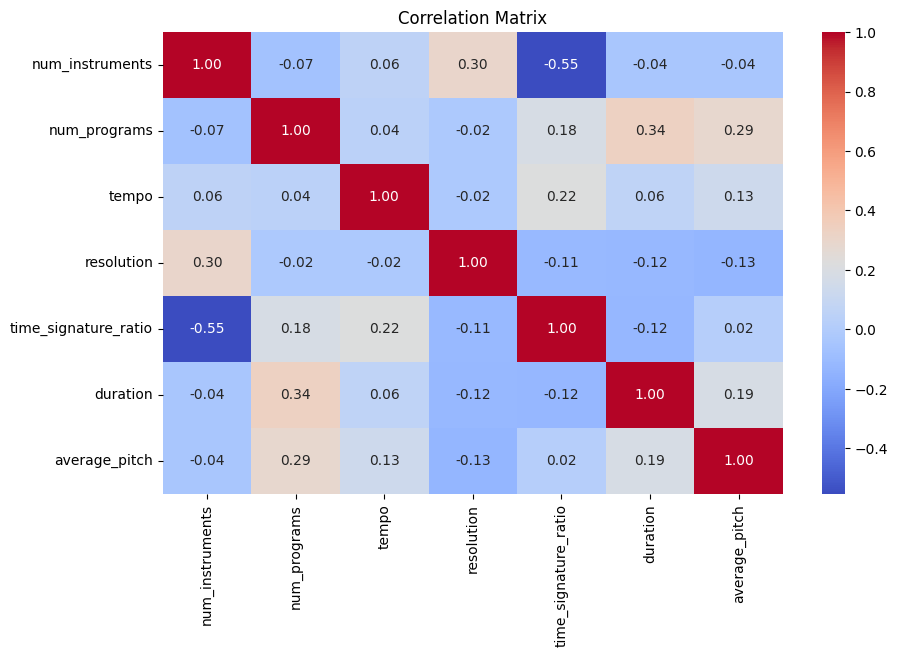

In [53]:
# Correlation Matrix
corr = df_clean[features].corr()

# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



# Normalization and Encoding

In [29]:
# Normalize the features using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])

# Display the first few rows of the normalized DataFrame
df_scaled.head()


label_encoder = LabelEncoder()
df_scaled['composer_encoded'] = label_encoder.fit_transform(df_scaled['composer'])

# Define the input features (X) and the target (y)
X = df_scaled[features].values
y = df_scaled['composer_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Model

In [30]:
# Define a function to create the LSTM model
def create_lstm_model(units, dropout_rate, input_shape):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 2, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 4),
        Dropout(dropout_rate),
        Dense(units // 8, activation='relu'),
        Dense(units // 16, activation='relu'),
        Dense(units // 32, activation='relu'),
        Dense(11, activation='softmax')
    ])
    return model

# Define the hyperparameters to tune
units = [2048]

# Define the dropout rates to tune
dropout_rates = [ 0.2]

# Define the input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize a list to store the results
results = []

# Loop through each combination of hyperparameters
for unit in units:
    for dropout_rate in dropout_rates:
        # Create the LSTM model
        model = create_lstm_model(unit, dropout_rate, input_shape)
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
        
        # Evaluate the model
        accuracy = model.evaluate(X_train, y_train, verbose=0)
        accuracy_percentage = accuracy[1] * 100
        
        # Store the results
        results.append({
            'units': unit,
            'dropout_rate': dropout_rate,
            'accuracy': accuracy_percentage
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df



C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


,units,dropout_rate,accuracy
0,2048,0.2,81.666666


# Classification Report

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


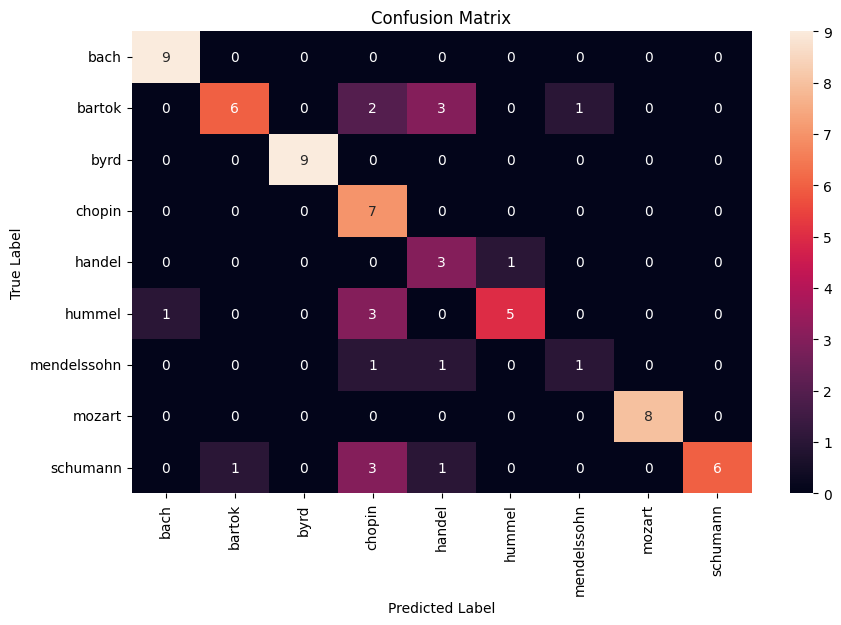

              precision    recall  f1-score   support

        bach       0.90      1.00      0.95         9
      bartok       0.86      0.50      0.63        12
        byrd       1.00      1.00      1.00         9
      chopin       0.44      1.00      0.61         7
      handel       0.38      0.75      0.50         4
      hummel       0.83      0.56      0.67         9
 mendelssohn       0.50      0.33      0.40         3
      mozart       1.00      1.00      1.00         8
    schumann       1.00      0.55      0.71        11

    accuracy                           0.75        72
   macro avg       0.77      0.74      0.72        72
weighted avg       0.83      0.75      0.75        72



In [15]:
# predict the test data
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_pred = model.predict(X_test)

# Convert the predicted values to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))



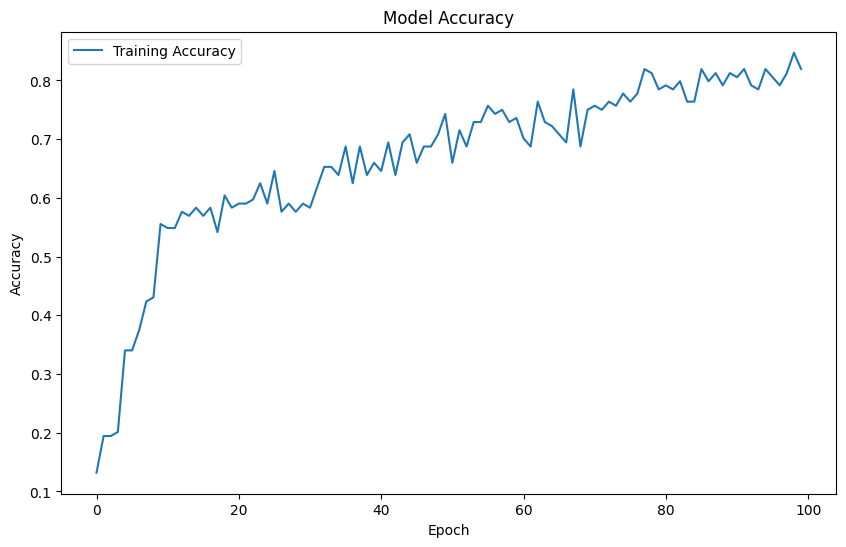

In [56]:
# Model Accuracy and Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



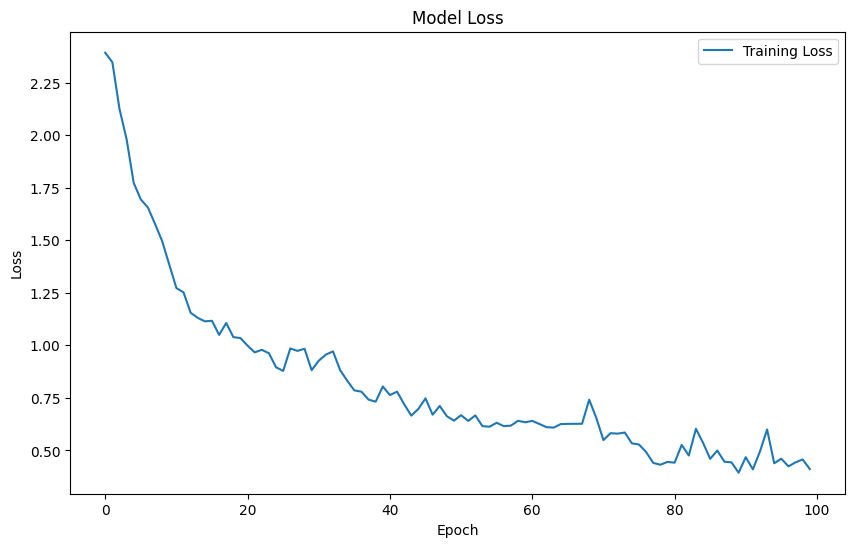

In [57]:
# Model Loss and Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
